In [1]:
import csv
import argparse
import zipfile
import pandas as pd
from pathlib import Path
import numpy as np, scipy.sparse as sp
import sys
from shapely.geometry import box, shape, Polygon,mapping

from datetime import datetime
import joblib

import os, json, h5py
from collections import Counter
import matplotlib.pyplot as plt
import geopandas as gpd
import pyvips
from pathlib import Path
from torch.utils.data import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score,classification_report,confusion_matrix,balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.linear_model import SGDClassifier
import argparse
import os
warnings.filterwarnings("ignore")

import torch
if torch.cuda.is_available(): print("CUDA is available! PyTorch can see the GPU.")
else: print("CUDA is not available. PyTorch will use the CPU.")

os.chdir('/scratch/users/ntu/lizh0106/nscc_work')
print(os.getcwd())

CUDA is not available. PyTorch will use the CPU.
/scratch/users/ntu/lizh0106/nscc_work


In [2]:
def build_save_path(
    base_dir,
    model_name,
    l2_norm,
    combine_2048,
):
    l2_str = "l2" if l2_norm else "nol2"
    comb_str = "with2048" if combine_2048 else "tileonly"

    run_name = f"{model_name}_{l2_str}_{comb_str}"
    save_path = os.path.join(base_dir, run_name)
    os.makedirs(save_path, exist_ok=True)

    return save_path

MODEL_LIST = ["XGB", "LR_SGD","MLP"]
MODEL = "XGB"

SAVE = False
COMBINE_2048 = True
L2_NORM = True

BASE_SAVE_DIR = "WsiBERT/models_Baseline"

save_path = build_save_path(BASE_SAVE_DIR,MODEL,L2_NORM,COMBINE_2048)

print("Saving to:", save_path)



Saving to: WsiBERT/models_Baseline/XGB_l2_with2048


In [3]:
def load_memmap_features(path, feat_dim=1024, dtype=np.float32, copy=True):
    """infer memmp shape"""

    path = os.fspath(path)
    itemsize = np.dtype(dtype).itemsize
    filesize = os.path.getsize(path)

    total_elems = filesize // itemsize
    assert total_elems % feat_dim == 0, "File size not divisible by feat_dim"

    n_samples = total_elems // feat_dim
    print (n_samples)
    mm = np.memmap(path,dtype=dtype,mode="r",shape=(n_samples, feat_dim))

    return mm.copy() if copy else mm

In [4]:
AGGC_features      = "Processed_Features/AGGC/20x_512/features.npy"
AGGC_f_index       = "Processed_Features/AGGC/20x_512/index.csv"
AGGC_tile_npz_path = "Processed_Features/AGGC/20x_512/AGGC_tile_targets_masks_names.npz"
AGGC_meta_path     = "WsiBERT/AGGC_metadata.csv"

TCGA_features = "Processed_Features/TCGA_PRAD/tcga_without_anno_arrays/20x_512/features.npy"
TCGA_f_index = "Processed_Features/TCGA_PRAD/tcga_without_anno_arrays/20x_512/index.csv"

TCGA_feats = load_memmap_features(TCGA_features)
AGGC_feats = load_memmap_features(AGGC_features)

AGGC_tnm = np.load(AGGC_tile_npz_path)

df_aggc_idx = pd.read_csv(AGGC_f_index)


1082970
1783610


In [5]:
# Y = AGGC_tnm["targets"]
# df_aggc_idx = pd.read_csv(AGGC_f_index)

# print(df_aggc_idx["y"].value_counts())

In [6]:
if COMBINE_2048:
    TCGA_features_2048 = "Processed_Features/TCGA_PRAD/tcga_without_anno_arrays_c_2048/2048/features.npy"
    AGGC_features_2048 = "Processed_Features/AGGC/AGGC_CENTER/AGGC_20x512/features.npy"

    TCGA_feats_2048, AGGC_feats_2048 = load_memmap_features(TCGA_features_2048), load_memmap_features(AGGC_features_2048)
    
    print(TCGA_feats_2048[0],AGGC_feats_2048[0])
    
    assert TCGA_feats.shape[0] == TCGA_feats_2048.shape[0]
    assert AGGC_feats.shape[0] == AGGC_feats_2048.shape[0]

    TCGA_feats = np.concatenate([TCGA_feats, TCGA_feats_2048], axis=1)
    AGGC_feats = np.concatenate([AGGC_feats, AGGC_feats_2048], axis=1)

1082970
1783610
[ 1.5648742   0.380017   -0.9344472  ... -0.2915135  -1.2149742
 -0.30855635] [ 1.7213401   1.7493136   0.17791243 ...  1.2015222  -0.66179436
  1.6378623 ]


In [7]:
def l2_norm_multiscale(X, eps=1e-8):
    """
    X: (N, D)
    If D == 2048: assume [512-scale | 2048-scale] concatenation
    If D != 2048: apply standard L2 norm
    """
    D = X.shape[1]

    if D == 2048:
        d = D // 2
        X1 = X[:, :d]
        X2 = X[:, d:]

        X1 = X1 / (np.linalg.norm(X1, axis=1, keepdims=True) + eps)
        X2 = X2 / (np.linalg.norm(X2, axis=1, keepdims=True) + eps)

        return np.concatenate([X1, X2], axis=1)

    else:
        return X / (np.linalg.norm(X, axis=1, keepdims=True) + eps)

# def l2_normalize_rows(X):
#     norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
#     return X / norms

if L2_NORM:
    TCGA_feats = l2_norm_multiscale(TCGA_feats)
    AGGC_feats = l2_norm_multiscale(AGGC_feats)

In [8]:
def normalize_probs(raw):
    '''return probs'''
    raw = raw.astype(np.float64)
    raw = np.clip(raw, 0, None)

    row_sums = raw.sum(axis=1, keepdims=True)   # (N, 1)
    nonzero = (row_sums.squeeze() != 0)         # (N,) 布尔向量

    raw[nonzero] /= row_sums[nonzero]
    if (~nonzero).any():
        raw[~nonzero] = 1.0 / raw.shape[1]

    return raw

In [9]:
X = AGGC_feats                  
Y = AGGC_tnm["targets"]

# stratify
y_major = Y.argmax(axis=1)
print("y_major counts:", np.bincount(y_major)) # target distribution

classes = np.unique(y_major)

print("unique", classes)

class_w = compute_class_weight(class_weight="balanced",
                               classes=classes,
                               y=y_major)
class_w_dict = {c: w for c, w in zip(classes, class_w)}

weights = np.array([class_w_dict[c] for c in y_major])
weights

y_major counts: [  83602  135072   11067 1553869]
unique [0 1 2 3]


array([0.28696274, 0.28696274, 0.28696274, ..., 0.28696274, 0.28696274,
       0.28696274], shape=(1783610,))

In [10]:
def slides_to_tile_indices(df_idx, slide_indices):
    """
    df_idx: df_aggc_idx
    slide_indices: indices of slides (from skf)
    return: np.array of tile indices
    """
    tile_idx = []
    for i in slide_indices:
        start  = df_idx.iloc[i]["start"]
        length = df_idx.iloc[i]["length"]
        tile_idx.append(np.arange(start, start + length))
    return np.concatenate(tile_idx)

In [ ]:
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

skf_slide = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

slide_y = df_aggc_idx["y"].values

n_samples  = X.shape[0]
classes_all = np.unique(y_major)
n_classes  = len(classes_all)

models = []

Train = True

if Train:
    cv_results = []
    oof_proba = np.zeros((n_samples, n_classes), dtype=np.float64)

    for fold, (slide_tr_idx, slide_val_idx) in enumerate(
            skf_slide.split(df_aggc_idx, slide_y), 1):

        train_idx = slides_to_tile_indices(df_aggc_idx, slide_tr_idx)
        val_idx   = slides_to_tile_indices(df_aggc_idx, slide_val_idx)

        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr_major  = y_major[train_idx]
        y_val_major = y_major[val_idx]

        weights_tr = np.array([class_w_dict[c] for c in y_tr_major],dtype=np.float64)

        # model = LogisticRegression(max_iter=1000,solver="lbfgs",multi_class="multinomial",class_weight="balanced",
        #                             n_jobs=-1)
        if MODEL ==  "LR_SGD":
            model = SGDClassifier(loss="log_loss",penalty="l2",alpha=1e-4,             
                                    max_iter=200,tol=1e-3,learning_rate="optimal",early_stopping=True,n_iter_no_change=5,     
                                    class_weight="balanced", random_state=42)
            model.fit(X_tr,y_tr_major,sample_weight=weights_tr,)
            #model.fit(X_tr,y_tr_major)

        if MODEL == "XGB":
            model = XGBClassifier(n_estimators=1000,max_depth=5,learning_rate=0.05,subsample=0.8,colsample_bytree=0.8,
                tree_method="hist", objective="multi:softprob",n_jobs=4,random_state=42,early_stopping_rounds=40,
                #device="cuda"
                )
            model.fit(X_tr,y_tr_major,sample_weight=weights_tr,eval_set=[(X_val, y_val_major)],verbose=False)

        if MODEL == "MLP":
            model = MLPClassifier(
                hidden_layer_sizes=(256, 64),   
                activation="relu",
                solver="adam",
                alpha=1e-4,                       
                batch_size=256,
                learning_rate_init=1e-3,
                max_iter=200,
                early_stopping=True,
                n_iter_no_change=10,
                random_state=42
            )
            model.fit(X_tr, y_tr_major, sample_weight=weights_tr)

        models.append(model)

        # -GPT modified version , a stable version
        pred_val_proba_fold = model.predict_proba(X_val)
        temp = np.zeros((len(val_idx), n_classes), dtype=np.float64)
        idx_map = np.searchsorted(classes_all, model.classes_)
        temp[:, idx_map] = pred_val_proba_fold
        oof_proba[val_idx] = temp

        if MODEL ==  "LR_SGD": print(f"Fold {fold} done. max n_iter = {np.max(model.n_iter_)}")

    oof_pred_labels = oof_proba.argmax(axis=1)    # prediction
    acc = accuracy_score(y_major, oof_pred_labels)
    b_acc = balanced_accuracy_score(y_major, oof_pred_labels)

    auc_macro = roc_auc_score(y_major,oof_proba,multi_class="ovr",average="macro")
    auc_each = roc_auc_score(y_major,oof_proba,multi_class="ovr",average=None)

    f1_macro    = f1_score(y_major, oof_pred_labels, average="macro")
    f1_weighted = f1_score(y_major, oof_pred_labels, average="weighted")

    print(f"  OOF accuracy     = {acc:.4f}")
    print(f"  OOF balanced accuracy     = {b_acc:.4f}")
    print(f"  OOF macro AUC    = {auc_macro:.4f}" if not np.isnan(auc_macro) else "  OOF macro AUC    = nan")
    print(f"  OOF macro F1     = {f1_macro:.4f}")
    print(f"  OOF weighted F1  = {f1_weighted:.4f}")
    print(f"  AUC per class    = {auc_each}")

    print("  Classification report:")
    print(classification_report(y_major, oof_pred_labels, digits=4))

    cv_results.append({
        "acc":         acc,
        "bacc": b_acc,
        "auc_macro":   auc_macro,
        "f1_macro":    f1_macro,
        "f1_weighted": f1_weighted,
        "auc_each":    auc_each,
    })

best = max(cv_results, key=lambda d: d["f1_macro"])
print("Details:", best)


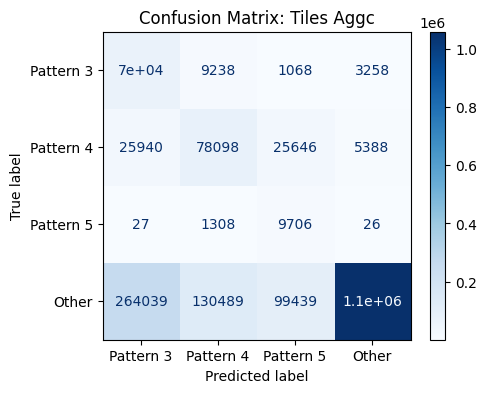

In [ ]:
# cm_tiles_aggc = confusion_matrix(y_major, oof_pred_labels)
# print(cm_tiles_aggc)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

target_names = ['Pattern 3', 'Pattern 4', 'Pattern 5', 'Other']
cm_tiles_aggc = confusion_matrix(y_major, oof_pred_labels)

fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tiles_aggc, display_labels=target_names)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix: Tiles Aggc')
plt.show()

In [ ]:
X_tcga = TCGA_feats  # (n_tcga, n_features)

tcga_proba_list = []

# predict tcga
for i, model in enumerate(models, 1):
    pred_tcga_proba = model.predict_proba(X_tcga)  # (n_tcga, n_classes)
    tcga_proba_list.append(pred_tcga_proba)
    print(f"TCGA prediction from fold {i} model done. Shape: {pred_tcga_proba.shape}")

# stack and average
tcga_proba_stack = np.stack(tcga_proba_list, axis=0)   # (n_folds, n_tcga, n_classes)
tcga_proba_mean  = tcga_proba_stack.mean(axis=0)       # (n_tcga, n_classes)

tcga_pred_labels = tcga_proba_mean.argmax(axis=1)      # (n_tcga,)

print("TCGA proba stack:", tcga_proba_stack.shape)
print("TCGA proba mean:",  tcga_proba_mean.shape)
print("TCGA pred labels:", tcga_pred_labels.shape)


TCGA prediction from fold 1 model done. Shape: (1082970, 4)
TCGA prediction from fold 2 model done. Shape: (1082970, 4)
TCGA prediction from fold 3 model done. Shape: (1082970, 4)
TCGA prediction from fold 4 model done. Shape: (1082970, 4)
TCGA prediction from fold 5 model done. Shape: (1082970, 4)
TCGA proba stack: (5, 1082970, 4)
TCGA proba mean: (1082970, 4)
TCGA pred labels: (1082970,)


In [ ]:
df_tcga_index_tiles = pd.read_csv(TCGA_f_index)
print(df_tcga_index_tiles.head(2))

                                            slide_id  y  start  length  \
0  TCGA-2A-A8VT-01Z-00-DX1.F2CD9AAB-7B40-46A4-832...  4      0    4794   
1  TCGA-2A-A8VX-01Z-00-DX1.2A244F16-C24E-4CE9-882...  3   4794    3295   

   n_tiles_read                                            h5_path  
0          4794  hole_removed_trident_size512mg20features_univ1...  
1          3295  hole_removed_trident_size512mg20features_univ1...  


In [ ]:

pattern_map = {0:3, 1:4, 2:5}   # G3/G4/G5

# ISUP 规则: Gleason → ISUP group(0-4)
def gleason_to_isup(g1, g2):
    score = g1 + g2
    if score <= 6:
        return 0     # ISUP 1
    elif score == 7:
        if g1 == 3 and g2 == 4:
            return 1  # ISUP 2
        elif (g1 == 4 and g2 == 3):
            return 2  # ISUP 3
    elif score == 8:
        return 3      # ISUP 4
    else:  # 9 or 10
        return 4      # ISUP 5
def agg_from_tiles(df_tcga_index_tiles,tcga_pred_labels):
    '''
    df_tcga_index_tiles: df with assigned rows
    tcga_pred_labels: tile labels from 0-3
    '''
    out_rows = []
    for i, row in df_tcga_index_tiles.iterrows():
        slide_id = row["slide_id"]
        start, end = row["start"], row["start"] + row["length"]

        tiles_preds = tcga_pred_labels[start:end]

        # G3/G4/G5
        counts = np.bincount(tiles_preds, minlength=4)
        tumor_counts = counts[:3]  ##Only tumor, no others
        total_tumor = tumor_counts.sum()

        if total_tumor == 0:
            # if no tumore tiles
            out_rows.append({
                "slide_id": slide_id,
                "p3": 0.0, "p4": 0.0, "p5": 0.0,
                "primary_pattern": None,
                "secondary_pattern": None,
                "gleason": None,
                "ISUP_grade_group": None
            })
            continue

        p3, p4, p5 = tumor_counts / total_tumor
        fractions = np.array([p3, p4, p5])

        # 排序，最多和第二多
        order = np.argsort(-fractions)
        p1_idx, p2_idx = order[0], order[1]
        p1, p2 = fractions[p1_idx], fractions[p2_idx]

        # 医学规则
        if p1 >= 0.95 or p2 < 0.05:
            g1 = g2 = pattern_map[p1_idx]    # 3+3, 4+4, 5+5
        else:
            g1 = pattern_map[p1_idx]
            g2 = pattern_map[p2_idx]

        gleason_str = f"{g1}+{g2}"
        isup = gleason_to_isup(g1, g2)

        out_rows.append({
            "slide_id": slide_id,
            "p3": float(p3),
            "p4": float(p4),
            "p5": float(p5),
            "primary_pattern": g1,
            "secondary_pattern": g2,
            "gleason": gleason_str,
            "ISUP_grade_group": isup
        })

    out_df = pd.DataFrame(out_rows)
    return out_df



# SAVE

In [ ]:
def evaluate_slide_predictions(out_df,truth_df,pred_col="ISUP_grade_group",true_col="ISUP_grade_group",
    treat_nan_as_class=5,verbose=True):

    pred_raw = out_df[pred_col].values
    true_raw = truth_df[true_col].values

    assert len(pred_raw) == len(true_raw), "Prediction and truth length mismatch."

    # ---------------------------
    # 2) Handle NaNs
    # ---------------------------
    nan_mask = np.isnan(pred_raw)

    pred_all = pred_raw.copy()
    pred_all[nan_mask] = treat_nan_as_class
    pred_all = pred_all.astype(int)
    true_all = true_raw.astype(int)

    # ---------------------------
    # 3) Metrics including NaN as a class
    # ---------------------------
    acc_all = accuracy_score(true_all, pred_all)
    labels_all = sorted(list(set(true_all)) + [treat_nan_as_class])
    #cm_all = confusion_matrix(true_all, pred_all, labels=labels_all)

    # ---------------------------
    # 4) Metrics excluding NaN
    # ---------------------------
    mask_valid = ~nan_mask
    pred_valid = pred_all[mask_valid]
    true_valid = true_all[mask_valid]

    acc_valid = accuracy_score(true_valid, pred_valid)
    cm_all = confusion_matrix(true_valid, pred_valid, labels=labels_all)
    bal_acc_valid = balanced_accuracy_score(true_valid, pred_valid)

    clf_report = classification_report(
        true_valid, pred_valid,
        labels=sorted(list(set(true_valid))),
        output_dict=False
    )

    # ---------------------------
    # 5) Optional printout
    # ---------------------------
    if verbose:
        print("=== Slide-level Evaluation ===")
        print(f"Slides with NaN predictions: {nan_mask.sum()} / {len(pred_raw)}\n")

        print("--- Including NaNs (as class {}) ---".format(treat_nan_as_class))
        print("Accuracy:", acc_all)

        print("--- Excluding NaNs ---")
        print("Accuracy:", acc_valid)
        print("Balanced accuracy:", bal_acc_valid)
        print("Confusion matrix:\n", cm_all, "\n")
        print("Classification report:\n", clf_report)

    # ---------------------------
    # 6) Return results
    # ---------------------------
    return {
        "nan_count": int(nan_mask.sum()),
        "acc_all": acc_all,
        "confusion_matrix_all": cm_all,
        "acc_valid": acc_valid,
        "balanced_acc_valid": bal_acc_valid,
        "classification_report": clf_report
    }


In [ ]:
out_tcga = agg_from_tiles(df_tcga_index_tiles,tcga_pred_labels)
truth_tcga_df = pd.read_csv("Processed_Features/TCGA_PRAD/final_data_2025NOV.csv")
true_df = truth_tcga_df[truth_tcga_df["have_valid_geojson"] == 0]

results_tcga = evaluate_slide_predictions(out_tcga, true_df)

=== Slide-level Evaluation ===
Slides with NaN predictions: 0 / 316

--- Including NaNs (as class 5) ---
Accuracy: 0.47468354430379744
--- Excluding NaNs ---
Accuracy: 0.47468354430379744
Balanced accuracy: 0.4036579576080193
Confusion matrix:
 [[ 5 12  4  4  0  0]
 [ 4 44 13 25 12  0]
 [ 0 19 34  8 12  0]
 [ 0  5  3  7 19  0]
 [ 0  5 14  7 60  0]
 [ 0  0  0  0  0  0]] 

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.20      0.29        25
           1       0.52      0.45      0.48        98
           2       0.50      0.47      0.48        73
           3       0.14      0.21      0.16        34
           4       0.58      0.70      0.63        86

    accuracy                           0.47       316
   macro avg       0.46      0.40      0.41       316
weighted avg       0.49      0.47      0.47       316



In [ ]:
if SAVE: 

    joblib.dump(models, os.path.join(save_path, "5fold.pkl")) # SAVE MODEL
    ########## SAVE WSI PRED GG GROUP 
    save_file = os.path.join(save_path, "tcga.csv")
    out_tcga.to_csv(save_file, index=False)

    print("Saved:", save_file)
    print(out_tcga.head())

    # SAVE  tiles pred proba aggc and tcga 
    np.save(os.path.join(save_path, "tcga_proba_mean.npy"), tcga_proba_mean)  
    #### we dont save tcga tile hard labels now
    np.save(os.path.join(save_path, "aggc_oof_tile_labels.npy"), oof_pred_labels)
    np.save(os.path.join(save_path, "aggc_oof_tile_proba.npy"), oof_proba)

# oof evaluation

In [ ]:
df_aggc_index_tiles = pd.read_csv(AGGC_f_index) ## TILE count df not metadata
out_aggc = agg_from_tiles(df_aggc_index_tiles,oof_pred_labels)

if SAVE: 
    save_file = os.path.join(save_path, "pred_aggc_oof.csv")
    out_aggc.to_csv(save_file, index=False)

    print("Saved:", save_file)
    print(out_aggc.head())

truth_aggc_df = pd.read_csv(AGGC_meta_path)

results_aggc = evaluate_slide_predictions(out_aggc, truth_aggc_df)


=== Slide-level Evaluation ===
Slides with NaN predictions: 0 / 187

--- Including NaNs (as class 5) ---
Accuracy: 0.4385026737967914
--- Excluding NaNs ---
Accuracy: 0.4385026737967914
Balanced accuracy: 0.3402331002331002
Confusion matrix:
 [[ 0  7  1  2  1  0]
 [ 3 45  5 24  1  0]
 [ 0 28 22  9  7  0]
 [ 0  1  4  2  3  0]
 [ 0  0  3  6 13  0]
 [ 0  0  0  0  0  0]] 

Classification report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.56      0.58      0.57        78
           2       0.63      0.33      0.44        66
           3       0.05      0.20      0.08        10
           4       0.52      0.59      0.55        22

    accuracy                           0.44       187
   macro avg       0.35      0.34      0.33       187
weighted avg       0.52      0.44      0.46       187



In [ ]:
def to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()   # 转成 python int/float
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_serializable(v) for v in obj]
    return obj

def save_json_metrics(metrics, filename):
    metrics = to_serializable(metrics)  # ← 关键一步

    metrics["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M")
    
    with open(filename, "w") as f:
        json.dump(metrics, f, indent=4)

if SAVE:
    save_json_metrics(results_aggc, os.path.join(save_path, "metrics_aggc.json"))
    save_json_metrics(results_tcga, os.path.join(save_path, "metrics_tcga.json"))

In [ ]:
# path_t = os.path.join(save_path, "metrics_aggc.json")

# with open(path_t, 'r') as f:
#     data = json.load(f)

# print(json.dumps(data))